# **1. Introduction**

Generative Adversarial Networks (GANs) have emerged as a powerful deep learning technique for generating realistic images. Among the many variations of GANs, Deep Convolutional GANs (DCGANs) have been particularly successful in generating high-quality synthetic images.

In this work, we implement a DCGAN to generate anime-style face images at a resolution of 64×64 pixels.
Our implementation follows the standard DCGAN architecture, which consists of a generator and a discriminator network competing in a minimax game.
The generator learns to produce realistic anime faces, while the discriminator learns to distinguish real images from synthetic ones. By training on a dataset of anime faces, the model progressively refines its ability to generate visually convincing images.

This notebook outlines the process of data preprocessing, network architecture design, training setup, and results evaluation.

# **2. Installing Required Libraries**
Before running this notebook, we have to ensure that all the required dependencies are installed. The necessary libraries include PyTorch, Torchvision, Matplotlib, and Kaggle API for dataset retrieval. The following cell installs any missing libraries.

In [1]:
!pip install torch torchvision numpy matplotlib

# **3. Importing Required Libraries**
Here, we import essential libraries for building and training the DCGAN model, handling datasets,
and visualizing results.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np

# **4. Loading and Preprocessing the Dataset**

## **4.1. Downloading the Dataset**
To train the DCGAN model, we use an anime face dataset available on Kaggle. The dataset consists of thousands of high-quality anime face images, which serve as the training data for our generative model. The dataset can be accessed at: https://www.kaggle.com/datasets/splcher/animefacedataset

In [3]:
!kaggle datasets download -d splcher/animefacedataset
!unzip animefacedataset.zip -d anime_faces/

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
100%|█████████████████████████████████████████| 395M/395M [00:02<00:00, 210MB/s]
100%|█████████████████████████████████████████| 395M/395M [00:02<00:00, 185MB/s]
Archive:  animefacedataset.zip
  inflating: anime_faces/images/0_2000.jpg  
  inflating: anime_faces/images/10000_2004.jpg  
  inflating: anime_faces/images/10001_2004.jpg  
  inflating: anime_faces/images/10002_2004.jpg  
  inflating: anime_faces/images/10003_2004.jpg  
  inflating: anime_faces/images/10004_2004.jpg  
  inflating: anime_faces/images/10005_2004.jpg  
  inflating: anime_faces/images/10006_2004.jpg  
  inflating: anime_faces/images/10007_2004.jpg  
  inflating: anime_faces/images/10008_2004.jpg  
  inflating: anime_faces/images/10009_2004.jpg  
  inflating: anime_faces/images/1000_2000.jpg  
  inflating: anime_faces/images/10010_2004.jpg  
  inflating: anime_faces/images/10011_2004.jpg  
  inflating: anime_faces/images/100

## **4.2. Hyperparameters for DCGAN Training**
The following hyperparameters are used for training the DCGAN model to generate anime face images:

In [4]:
# Hyperparameters
config = {
    "image_size": 64,
    "batch_size": 128,
    "nz": 100,  # Latent vector size
    "num_epochs": 100,
    "lr": 0.0002,
    "beta1": 0.5,  # Adam optimizer beta1
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "nrow": 6  # Number of images per row (6x4 = 24 images per grid)
}

## **4.3. Applying Transformations and Creating a DataLoader**
Before feeding the images into the model, we define a transformation pipeline for our dataset. We resize and crop the images to 64x64, convert them to tensors, and normalize them to the range [-1,1]. We then load the dataset from the "anime_faces/" directory using ImageFolder, applying our transformations. Finally, we create a dataloader with a batch size of 128 and enable shuffling for better training dynamics.

In [5]:
# DataLoader
dataset = dset.ImageFolder(root="anime_faces/", transform=transforms.Compose([
    transforms.Resize(config["image_size"]),
    transforms.CenterCrop(config["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=config["batch_size"], shuffle=True)

## **4.4. Viewing a Sample from the Dataset**
We first visualize a batch of sample images from our dataset. We first retrieve a batch from the dataloader and denormalize the images to bring them back to a [0,1] range. Then, we use matplotlib and torchvision.utils.make_grid to display a grid of 24 images, giving us a quick look at how our dataset appears before training.

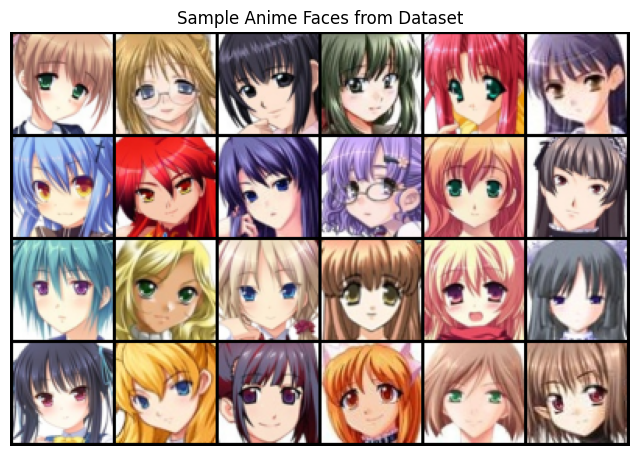

In [6]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Get a batch of images from the DataLoader
dataiter = iter(dataloader)
images, _ = next(dataiter)

# Denormalize the images (since they were normalized to [-1,1])
def denormalize(img):
    return img * 0.5 + 0.5  # Convert back to range [0,1]

# Display the images
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Sample Anime Faces from Dataset")
plt.imshow(vutils.make_grid(denormalize(images[:24]), nrow=6).permute(1, 2, 0))  # Show first 16 images
plt.show()

# **5. Defining the DCGAN Model**
The Deep Convolutional Generative Adversarial Network (DCGAN) consists of a Generator and a Discriminator. The Generator creates synthetic images, while the Discriminator classifies images as real or fake.

## **5.1. Generator**
The Generator is a neural network that takes random noise as input and generates an image. It uses transposed convolutional layers and batch normalization to upsample the input into a realistic image.
Here, we define the generator network for our DCGAN. It takes a random noise vector as input and progressively upsamples it using transposed convolution layers, batch normalization, and ReLU activations to generate 64x64 images. The final layer uses a Tanh activation to output images in the range [-1,1].

In [7]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

## **5.2. Discriminator**
The Discriminator is a convolutional neural network that distinguishes between real and fake images.
It outputs a probability indicating how likely an image is real.
Here, we define the discriminator network for our DCGAN. It takes a 64x64 image as input and progressively downsamples it using convolutional layers with spectral normalization for stability. Leaky ReLU activations are used to improve gradient flow. The final layer outputs a single value between 0 and 1, representing whether the image is real or fake.

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# **6. Initalizing Models & Setting up Training**
In this step, we set up the training environment for our DCGAN. We check for GPU availability and move the generator and discriminator to the appropriate device. Binary Cross Entropy Loss is used as the loss function. We initialize Adam optimizers with learning rate = 0.0002 for the generator and discriminator. A fixed noise vector is also created to generate consistent images for evaluation during training.

In [9]:
# Initialize models, loss, and optimizers
netG = Generator(config["nz"]).to(config["device"])
netD = Discriminator().to(config["device"])
criterion = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=config["lr"], betas=(config["beta1"], 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=config["lr"], betas=(config["beta1"], 0.999))

# Fixed noise for visualization
fixed_noise = torch.randn(24, config["nz"], 1, 1, device=config["device"])

# **7. Training the DCGAN**
We now implement the training loop for our DCGAN by alternating between training generator and discriminator. We train the discriminator by optimizing its ability to distinguish real and fake images. The generator is trained by trying to fool the discriminator into classifying generated images as real. Losses for both networks are recorded for analysis. Every 100 steps, we print the current losses, and at the end of each epoch, we save a set of generated images for progress tracking.

In [10]:
# Training Loop
G_losses, D_losses = [], []
num_epochs = config["num_epochs"]
generated_images = {}

def train_dcgan():
    """Train the DCGAN model and save generated images every 10 epochs."""
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(config["device"])
            batch_size = real_images.size(0)

            # Label smoothing
            real_labels = torch.full((batch_size,), 0.9, device=config["device"])  # Real labels slightly lower than 1
            fake_labels = torch.zeros(batch_size, device=config["device"])  # Fake labels as 0

            # Train Discriminator
            netD.zero_grad()
            output_real = netD(real_images).view(-1)
            loss_real = criterion(output_real, real_labels)
            loss_real.backward()

            noise = torch.randn(batch_size, config["nz"], 1, 1, device=config["device"])
            fake_images = netG(noise)
            output_fake = netD(fake_images.detach()).view(-1)
            loss_fake = criterion(output_fake, fake_labels)
            loss_fake.backward()
            optimizerD.step()

            # Train Generator
            netG.zero_grad()
            fake_labels.fill_(1)  # Flip fake labels to real (1)
            output = netD(fake_images).view(-1)
            loss_gen = criterion(output, fake_labels)
            loss_gen.backward()
            optimizerG.step()

            # Store losses
            D_losses.append((loss_real.item() + loss_fake.item()))
            G_losses.append(loss_gen.item())

            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], D Loss: {D_losses[-1]:.4f}, G Loss: {G_losses[-1]:.4f}")

        # Store generated images at the first epoch and every 20th epoch
        if epoch == 0 or ((epoch + 1) % 20 == 0):
            with torch.no_grad():
                fake_images = netG(fixed_noise).detach().cpu()
                generated_images[epoch + 1] = fake_images

# Run training
train_dcgan()

Epoch [1/100], Step [0/497], D Loss: 1.4475, G Loss: 2.5340
Epoch [1/100], Step [100/497], D Loss: 0.5268, G Loss: 5.1349
Epoch [1/100], Step [200/497], D Loss: 1.4046, G Loss: 2.5574
Epoch [1/100], Step [300/497], D Loss: 0.6455, G Loss: 3.5272
Epoch [1/100], Step [400/497], D Loss: 1.0861, G Loss: 1.7313
Epoch [2/100], Step [0/497], D Loss: 0.6047, G Loss: 4.2184
Epoch [2/100], Step [100/497], D Loss: 1.0764, G Loss: 8.6097
Epoch [2/100], Step [200/497], D Loss: 0.6446, G Loss: 3.9349
Epoch [2/100], Step [300/497], D Loss: 0.9031, G Loss: 8.1271
Epoch [2/100], Step [400/497], D Loss: 0.5903, G Loss: 3.8404
Epoch [3/100], Step [0/497], D Loss: 0.4879, G Loss: 3.5764
Epoch [3/100], Step [100/497], D Loss: 0.8309, G Loss: 6.8381
Epoch [3/100], Step [200/497], D Loss: 1.0336, G Loss: 7.7920
Epoch [3/100], Step [300/497], D Loss: 1.8064, G Loss: 5.1020
Epoch [3/100], Step [400/497], D Loss: 0.6047, G Loss: 5.9744
Epoch [4/100], Step [0/497], D Loss: 0.5153, G Loss: 4.5402
Epoch [4/100], S

# **8. Saving the Trained Model**
After training, we save and download the model so it can be used later for generating new anime faces on demand at our web-page browser on Hugging Face Spaces.

In [11]:
# Save the models
torch.save(netG.state_dict(), "/kaggle/working/generator.pth")
torch.save(netD.state_dict(), "/kaggle/working/discriminator.pth")

print("Models saved successfully!")

Models saved successfully!


# **9. Visualizing Results**
Finally, we visualize the training progress of our DCGAN. First, we plot the generator and discriminator losses over iterations to track how well the networks are learning. Then, we load and display selected generated images from specific epochs to observe how the quality of the generated anime faces evolves over time.

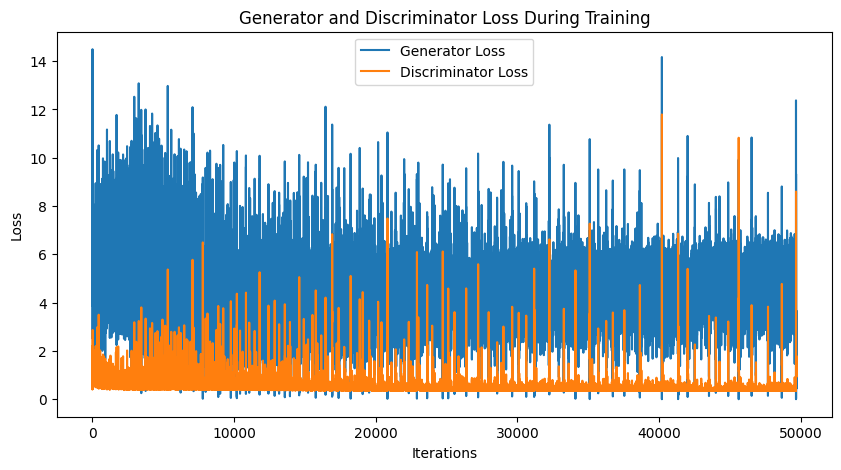

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

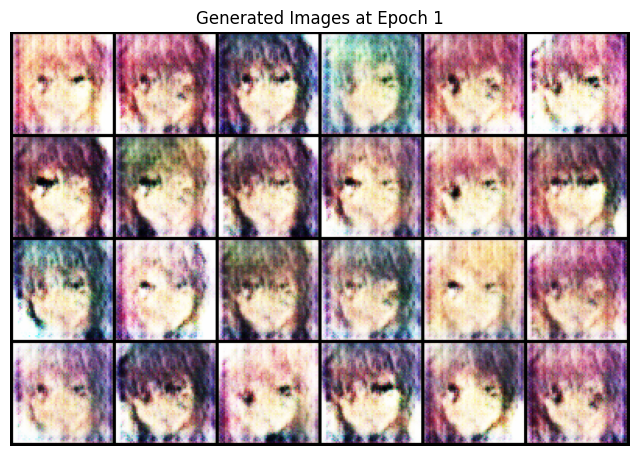

Saved: /kaggle/working/generated_images/epoch_1.png


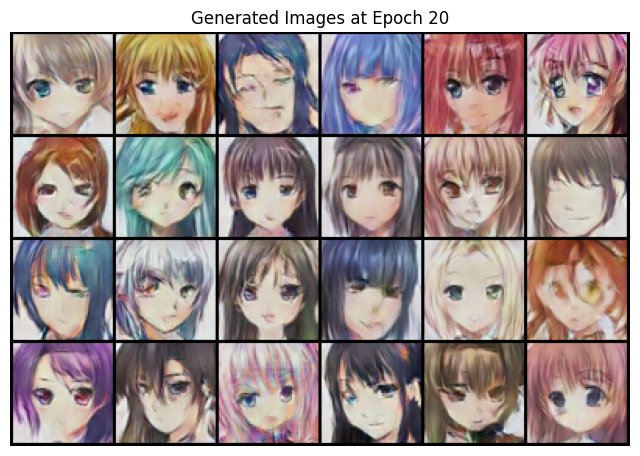

Saved: /kaggle/working/generated_images/epoch_20.png


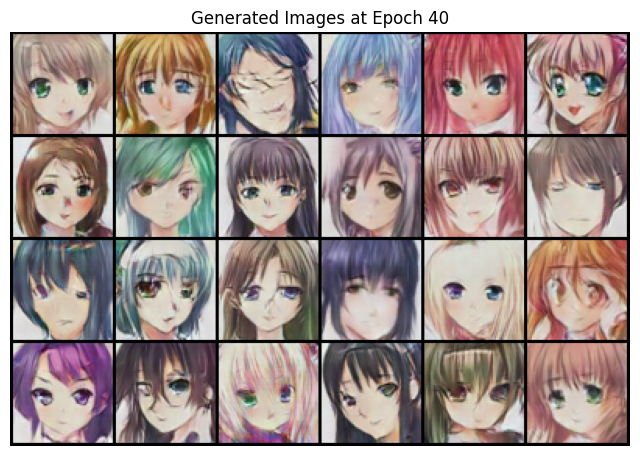

Saved: /kaggle/working/generated_images/epoch_40.png


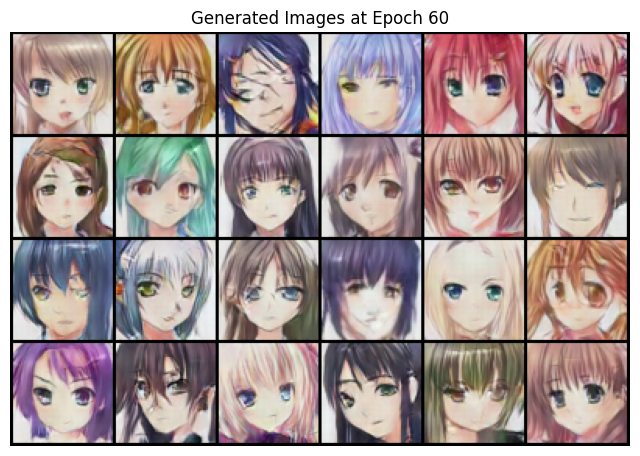

Saved: /kaggle/working/generated_images/epoch_60.png


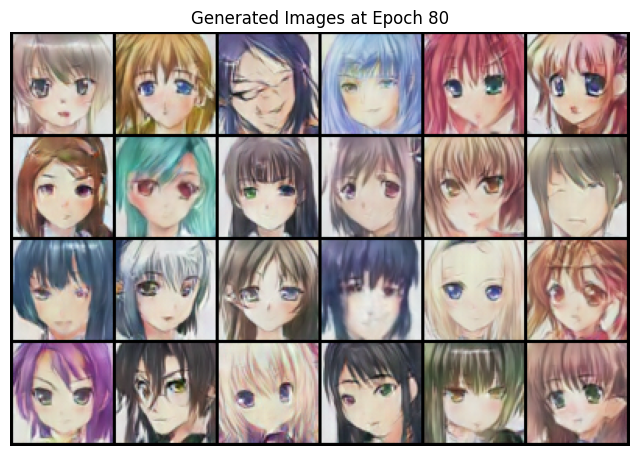

Saved: /kaggle/working/generated_images/epoch_80.png


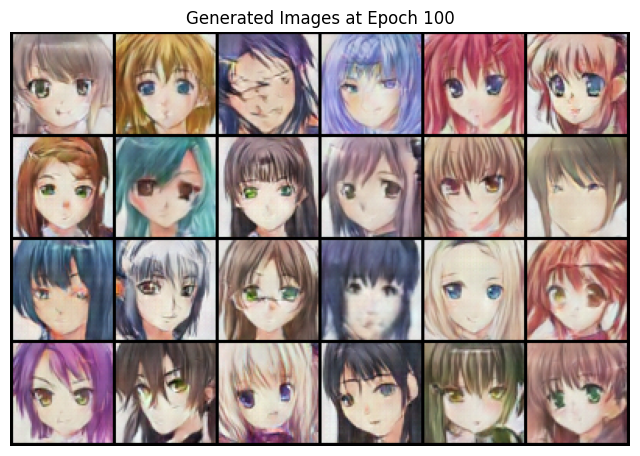

Saved: /kaggle/working/generated_images/epoch_100.png


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Create a directory to store images
save_dir = "/kaggle/working/generated_images"
os.makedirs(save_dir, exist_ok=True)

# Display and save stored generated images every 20 epochs
for epoch, img in generated_images.items():
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Generated Images at Epoch {epoch}")
    
    # Convert image to numpy format for saving
    img_grid = np.transpose(vutils.make_grid(img, nrow=config["nrow"], normalize=True).cpu(), (1, 2, 0))
    plt.imshow(img_grid)
    
    # Save the image
    save_path = f"{save_dir}/epoch_{epoch}.png"
    plt.savefig(save_path)

    # Show the image
    plt.show()

    # Close the plot to avoid excessive memory usage
    plt.close()

    print(f"Saved: {save_path}")